## Neural Network Project 2
## LEGO Kaggle Dataset

Dominic Allard

Samuel Hartle


### Preprocessing the Data

In [8]:
# Importing basics
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow import keras
import os

Load and display one of the images

float32
(400, 400, 3)


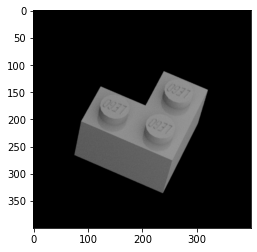

In [40]:
# Define file path
path = r"C:\Users\allar\Documents\Neural Networks\Project 2\LEGOS\dataset"
# Load as display an image
first = mpl.image.imread(path + "\\2357 brick corner 1x2x2 000L.png")
print(first.dtype)
print(first.shape)
plt.imshow(first)
plt.show()

We need to extract the file names from the titles of the images.

In [41]:
# Extract file names
def load_names(directory):
    f = []
    for (filenames) in os.walk(directory):
        f.extend(filenames)
        break
    return f
data = pd.DataFrame(load_names(path) [2])

# Let's check:
print(data.shape)
print(data)

(39995, 1)
                                         0
0      14719 flat tile corner 2x2 002R.png
1      14719 flat tile corner 2x2 003L.png
2      14719 flat tile corner 2x2 003R.png
3      14719 flat tile corner 2x2 004L.png
4      14719 flat tile corner 2x2 004R.png
...                                    ...
39990  99301 roof tile inside 3x3 397R.png
39991  99301 roof tile inside 3x3 398L.png
39992  99301 roof tile inside 3x3 398R.png
39993  99301 roof tile inside 3x3 399L.png
39994  99301 roof tile inside 3x3 399R.png

[39995 rows x 1 columns]


With that done, let's make a table with all the labels

In [42]:
# Make a table for all the labels
# Rename the first column for clarity
data.rename(columns = {0:"file_name"}, inplace=True)
# Extract the piece id at the beginning of the filename
data["piece_id"] = data["file_name"].str.split(" ").str[0]
# Drop the filename before drop duplicates
data = data.drop(["file_name"], axis=1)
# Drop duplicates
data = data.drop_duplicates()
# Reset ids
data = data.reset_index(drop=True)
# We convert the string id to numeric id
data["piece_id"] = pd.to_numeric(data["piece_id"])

# Let's check the size
print(data.shape)
print(data)

(50, 1)
    piece_id
0      14719
1      15672
2      18654
3       2357
4       2420
5       2780
6      27925
7       3001
8       3002
9       3003
10      3004
11      3005
12      3010
13      3020
14      3021
15      3022
16      3023
17      3024
18      3037
19      3038
20      3039
21      3040
22      3045
23      3046
24      3062
25      3063
26      3068
27      3069
28      3070
29      3298
30     33909
31      3622
32      3623
33      3659
34      3675
35      3700
36      3794
37      4150
38     41677
39     41678
40      4274
41      4286
42     43093
43     43857
44      4490
45     54200
46      6143
47      6632
48     85984
49     99301


Table done. Make a dictionary of the labels. 

In [43]:
# Set a dictionary
# Dictionary of piece_id's with the order id that will be used in the classifier
dic = data.to_dict("dict")["piece_id"]

# Set two useful id vectors
conversion_vector = [i for i in range(len(dic))]
print(conversion_vector)
conversion_empty = [0 for i in range(len(dic))]
print(conversion_empty)

# General variables
CLASS_NAMES = data["piece_id"]
NB_CLASSES = len(CLASS_NAMES)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Need to randomly suffle the images. Setting a random seed first.

In [44]:
# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

Load files in and shuffle.

In [52]:
# Load files
# Load file names, all in the dataset directory, we remove auto shuffle
list_ds = tf.data.Dataset.list_files(str(path + '*'), shuffle=False)

# We shuffle the list, but not at each iteration because as we don't want train, test and validation datasets to overlap on a new run
list_ds = list_ds.shuffle(40000, seed=42, reshuffle_each_iteration=False)

# We check 2x list_ds is always shuffled in the same order
for i in list_ds.take(5):
    print(i.numpy())
for i in list_ds.take(5):
    print(i.numpy())

b'C:\\Users\\allar\\Documents\\Neural Networks\\Project 2\\LEGOS\\dataset\\3024 plate 1x1 106R.png'
b'C:\\Users\\allar\\Documents\\Neural Networks\\Project 2\\LEGOS\\dataset\\99301 roof tile inside 3x3 321R.png'
b'C:\\Users\\allar\\Documents\\Neural Networks\\Project 2\\LEGOS\\dataset\\3002 brick 2x3 229L.png'
b'C:\\Users\\allar\\Documents\\Neural Networks\\Project 2\\LEGOS\\dataset\\3623 Plate 1x3 314R.png'
b'C:\\Users\\allar\\Documents\\Neural Networks\\Project 2\\LEGOS\\dataset\\43857 beam 1x2 246L.png'
b'C:\\Users\\allar\\Documents\\Neural Networks\\Project 2\\LEGOS\\dataset\\3024 plate 1x1 106R.png'
b'C:\\Users\\allar\\Documents\\Neural Networks\\Project 2\\LEGOS\\dataset\\99301 roof tile inside 3x3 321R.png'
b'C:\\Users\\allar\\Documents\\Neural Networks\\Project 2\\LEGOS\\dataset\\3002 brick 2x3 229L.png'
b'C:\\Users\\allar\\Documents\\Neural Networks\\Project 2\\LEGOS\\dataset\\3623 Plate 1x3 314R.png'
b'C:\\Users\\allar\\Documents\\Neural Networks\\Project 2\\LEGOS\\dataset\\4

Train/test/val split the data.

In [47]:
# Train, test, validation split
# Split
train_size = int(32000)
val_size = int(3200)
test_size = int(4800)

train_ds = list_ds.take(train_size)
test_ds = list_ds.skip(train_size)
val_ds = test_ds.skip(test_size)
test_ds = test_ds.take(test_size)

# Check dataset size
print(tf.data.experimental.cardinality(train_ds))
print(tf.data.experimental.cardinality(test_ds))
print(tf.data.experimental.cardinality(val_ds))

tf.Tensor(32000, shape=(), dtype=int64)
tf.Tensor(4800, shape=(), dtype=int64)
tf.Tensor(3196, shape=(), dtype=int64)


Need a bit more preprocessing so that we can feed the data into the CNN.

In [48]:
# Load and resize images to tensor with floats in the [0,1] range, at a specific size for the CNN
def decode_img(img):
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [224, 224])

# Get the label corresponding to the image returning a number in the [0,50] range , corresponding to the id in the earlier DataFrame
def get_label(file_path):
    parts=tf.strings.split(file_path,
                 os.path.sep)[-1]
    parts=tf.strings.split(parts, " ")[0]
    parts=tf.strings.to_number(parts, out_type=tf.dtypes.int64) 
    parts=tf.where(parts==CLASS_NAMES, conversion_vector, conversion_empty)
    return tf.math.reduce_sum(parts)

# Return Images and their corresponding label (id)
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

Load preprocessed data.

In [49]:
# Create Loading using parallel calls, hypermeters hasn't been tweaked
train_load = train_ds.map(process_path, num_parallel_calls=50)
test_load = test_ds.map(process_path, num_parallel_calls=50)
val_load = val_ds.map(process_path, num_parallel_calls=50)

# Check 5 images in the train dataset
for image, label in train_load.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  17
Image shape:  (224, 224, 3)
Label:  49
Image shape:  (224, 224, 3)
Label:  8
Image shape:  (224, 224, 3)
Label:  32
Image shape:  (224, 224, 3)
Label:  43


Shuffle the data again and prepare it for training. 

In [50]:

# Cache parameter was originally set on True
def prepare_for_training(ds, cache=False, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
    else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=True)
    # Repeat forever after shuffling at each iteration, as the sets are now clearly distinct to have different batches at each epoch
    ds = ds.repeat()
  
    # Batch by 8, this was the highest value possible with my GPU/CPU
    ds = ds.batch(8)
  
    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training. Bufer size is an hyperparameter that hasn't been tweaked, set to 1.
    ds = ds.prefetch(buffer_size=1)
    return ds

Set our train, test, and validation dataset.

In [53]:
train_set = prepare_for_training(train_load)
val_set = prepare_for_training(val_load)
test_set = prepare_for_training(test_load)